## Fashion MNIST Dataset을 사용하여 분류 실습
DNN (Deep Neural Network)를 사용하여 Fashion MNIST 데이터셋을 분류해보자.

In [1]:
### 라이브러리 임포트
import os
import sys

import logging		# 코드의 출력 결과를 기록하기 위한 라이브러리
import argparse		# hyper parameter를 조절하기 위한 라이브러리
import random		

import torch					                # 신경망 학습을 위한 라이브러리
import torch.nn as nn				            # 신경망 학습을 위한 라이브러리						
import torch.optim as optim			            # Optimizer를 사용하기 위한 라이브러리
from torchvision import datasets, transforms	# 데이터셋을 다운로드 및 변환하기 위한 라이브러리
import numpy as np				                # 리스트 조작을 위한 라이브러리

from matplotlib import pyplot as plt	# 시각화를 위한 라이브러리

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))
# utils 함수를 생성하여 함수 초기화, logging 등을 도와주는 파일입니다.
from utils import AverageMeter, config_logging

In [2]:
# argument 세팅
parser = argparse.ArgumentParser(description='Fashion MNIST Classfication')

parser.add_argument('--batch_size', default=64, type=int,
                    help='Dataset batch_size')
parser.add_argument('--num_epochs', default=50, type=int,
                    help='num epochs')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate')

parser.add_argument('--comment', type=str, default='')


args = parser.parse_args('')	# 단순 python 파일로 실행할 때는 () 안에 ''를 넣지 않습니다.
comment = args.comment

config_logging(comment)
logging.info('args: {}'.format(args))

2022-03-05 16:46:59,884 [INFO ] args: Namespace(batch_size=64, comment='', learning_rate=0.001, num_epochs=50)


Fashion_MNIST


In [3]:
### GPU 설정
device = torch.device("cuda:0")
logging.info("device: {}".format(device))

2022-03-05 16:47:00,483 [INFO ] device: cuda:0


In [4]:
### transform 설정
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

### Fashion MNIST Dataset
* 60,000개의 train data, 10,000개의 test data로 이루어짐
* 0 - T-Shirts </br>
1 - Trouser </br>
2- Pullover </br>
3 - Dress </br>
4 - Coat </br>
5 - Sandal </br>
6 - Shirt </br>
7 - Sneanker </br>
8 - Bag </br>
9 - Ankle boot 와 같은 클래스를 갖는 데이터셋
* 한장의 이미지는 28x28의 크기를 갖음


In [5]:
### Dataset 다운로드
root = '../MNIST_Fashion'
trainset = datasets.FashionMNIST(root=root, 
                                 download=True, 
                                 train=True, 
                                 transform=transform)
testset = datasets.FashionMNIST(root=root,
                                 download=True,  
                                 train=False, 
                                 transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size=args.batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, 
                                          batch_size=args.batch_size, 
                                          shuffle=False)

logging.info("train data length: {}, test data length: {}".format(len(trainset), len(testset)))

C:\Users\user\anaconda3\envs\transformer\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
2022-03-05 16:47:02,562 [INFO ] train data length: 60000, test data length: 10000


### 데이터셋 시각화

In [6]:
def imshow(img):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1,2,0)))
    plt.axis('off')
    plt.show()

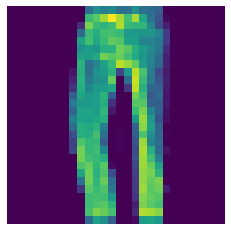

Category is a Trouser


In [7]:
label_tags = {
    0: 'T-Shirt', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat', 
    5: 'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle Boot'
}

idx = random.randint(0,64)

sample_data = iter(train_loader)
images, labels = next(sample_data)
imshow(images[idx])
print('Category is a {}'.format(label_tags[labels[idx].item()]))

In [8]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        
        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
    
    def forward(self, x):
        x = self.layer(x)
        
        return x

In [9]:
model = DNN()
epochs = args.num_epochs

total_loss = []
for epoch in range(1, epochs+1):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

    logging.info('Train Phase, Epochs: {}'.format(epoch))
    model.train()
    train_loss = AverageMeter()

    for batch_num, data in enumerate(train_loader):
        images, labels = data

        images = images.view(-1,28*28).to(device)
        labels = labels.to(device)

        output = model(images)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.update(loss.item(), images.shape[0])
        
        if batch_num % 100 == 0:
            logging.info(
                "[{}/{}] # {}/{} loss: {:.4f}".format(epoch, epochs, 
                                                     batch_num, len(train_loader), train_loss.val)
            )
    total_loss.append(train_loss.avg)

2022-03-04 18:03:55,893 [INFO ] Train Phase, Epochs: 1
2022-03-04 18:03:56,599 [INFO ] [1/50] # 0/938 loss: 2.3181
2022-03-04 18:03:57,625 [INFO ] [1/50] # 100/938 loss: 0.7193
2022-03-04 18:03:58,674 [INFO ] [1/50] # 200/938 loss: 0.6349
2022-03-04 18:03:59,690 [INFO ] [1/50] # 300/938 loss: 0.3814
2022-03-04 18:04:00,680 [INFO ] [1/50] # 400/938 loss: 0.3450
2022-03-04 18:04:01,666 [INFO ] [1/50] # 500/938 loss: 0.5773
2022-03-04 18:04:02,685 [INFO ] [1/50] # 600/938 loss: 0.5079
2022-03-04 18:04:03,695 [INFO ] [1/50] # 700/938 loss: 0.4953
2022-03-04 18:04:04,693 [INFO ] [1/50] # 800/938 loss: 0.7759
2022-03-04 18:04:05,722 [INFO ] [1/50] # 900/938 loss: 0.2372
2022-03-04 18:04:06,093 [INFO ] Train Phase, Epochs: 2
2022-03-04 18:04:06,109 [INFO ] [2/50] # 0/938 loss: 0.3014
2022-03-04 18:04:07,107 [INFO ] [2/50] # 100/938 loss: 0.4591
2022-03-04 18:04:08,099 [INFO ] [2/50] # 200/938 loss: 0.4359
2022-03-04 18:04:09,093 [INFO ] [2/50] # 300/938 loss: 0.4341
2022-03-04 18:04:10,080 [I

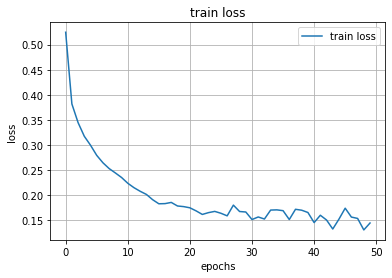

In [10]:
plt.plot(total_loss)
plt.title('train loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.legend(['train loss'])
plt.show()

In [11]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

count = 0
ans = 0

class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

logging.info('Test Phase...')
with torch.no_grad():
    model.eval()

    for batch_num, data in enumerate(test_loader):
        images, labels = data

        images = images.view(-1,28*28).to(device)
        labels = labels.to(device)

        output = model(images)
        predict = torch.max(output, 1)[1].to(device)
        is_correct = (predict == labels).squeeze()

        for i in range(len(is_correct)):
            label = labels[i]
            
            ans += is_correct[i].item()   
            count += 1
            
            class_correct[label] += is_correct[i].item()
            total_correct[label] += 1

logging.info('Total Accuracy: {:.4f}%'.format((ans/count)*100))

for i in range(10):
    logging.info("Accuracy of class {}: {:.4f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

2022-03-04 18:11:41,436 [INFO ] Test Phase...
2022-03-04 18:11:44,624 [INFO ] Total Accuracy: 88.2500%
2022-03-04 18:11:44,626 [INFO ] Accuracy of class T-shirt/Top: 77.5000%
2022-03-04 18:11:44,626 [INFO ] Accuracy of class Trouser: 98.2000%
2022-03-04 18:11:44,626 [INFO ] Accuracy of class Pullover: 88.8000%
2022-03-04 18:11:44,626 [INFO ] Accuracy of class Dress: 86.1000%
2022-03-04 18:11:44,626 [INFO ] Accuracy of class Coat: 75.8000%
2022-03-04 18:11:44,627 [INFO ] Accuracy of class Sandal: 96.6000%
2022-03-04 18:11:44,627 [INFO ] Accuracy of class Shirt: 70.6000%
2022-03-04 18:11:44,628 [INFO ] Accuracy of class Sneaker: 96.6000%
2022-03-04 18:11:44,628 [INFO ] Accuracy of class Bag: 97.0000%
2022-03-04 18:11:44,629 [INFO ] Accuracy of class Ankle Boot: 95.3000%


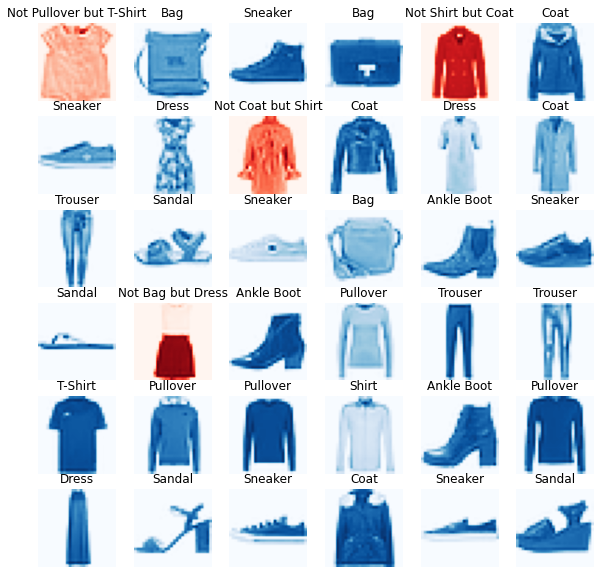

In [12]:
label_tags = {
    0: 'T-Shirt', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat', 
    5: 'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle Boot'
}
columns = 6
rows = 6
fig = plt.figure(figsize=(10,10))
 
model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(testset))
    input_img = testset[data_idx][0].unsqueeze(dim=0).to(device) 
 
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = label_tags[argmax.item()]
    label = label_tags[testset[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred)
        cmap = 'Blues'
    else:
        plt.title('Not ' + pred + ' but ' +  label)
        cmap = 'Reds'
    plot_img = testset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')
    
plt.show() 